# Covariance Matrix Adaptation MAP-Annealing (CMA-MAE) and Archive Thresholds

**This tutorial assumes that you are familiar with Covariance Matrix Adaptation MAP-Elites (CMA-ME).** 

If you are not familiar with CMA-ME, we recommend reading through and playing around with the following tutorials:
- [Using CMA-ME to Land a Lunar Lander Like a Space Shuttle](https://docs.pyribs.org/en/latest/tutorials/lunar_lander.html)
- [Illuminating the Latent Space of an MNIST GAN](https://docs.pyribs.org/en/latest/tutorials/lsi_mnist.html)

## Setup

Firstly, let's import some utility libraries that we will use later.

In [ ]:
# Install latest pyribs (temporary for collab, remove after pip formula is updated)
!git clone https://github.com/icaros-usc/pyribs.git
!pip install ./pyribs

import matplotlib.pyplot as plt
import numpy as np

Secondly, let's define **the sphere function and its gradients**.

It is not important to understand the implementation of this method, but it is important to understand how this particular sphere function differs from the standard [sphere function](https://en.wikipedia.org/wiki/Sphere).

The particular sphere function used in this example is adapted from Section 4 of [Fontaine 2020](https://arxiv.org/abs/1912.02400). Namely, each solution value is clipped to the range $[-5.12, 5.12]$, and the optimum is moved from $[0,..]$ to $[0.4 \times 5.12 = 2.048,..]$. Furthermore, the objectives are normalized to the range $[0,100]$ where $100$ is the maximum and corresponds to $0$ on the original sphere function.

There are two measures in this example. The first is the sum of the first $\frac{n}{2}$ clipped values of the solution, and the second is the sum of the last $\frac{n}{2}$ clipped values of the solution. Having each measure depend equally on several values in the solution space makes the problem more difficult (refer to [Fontaine 2020](https://arxiv.org/abs/1912.02400) for more information).

In [ ]:
def sphere(solution_batch):
  """Sphere function evaluation and measures for a batch of solutions.

  Args:
      solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
  Returns:
      objective_batch (np.ndarray): (batch_size,) batch of objectives.
      measures_batch (np.ndarray): (batch_size, 2) batch of measures.
  """
  dim = solution_batch.shape[1]

  # Shift the Sphere function so that the optimal value is at x_i = 2.048.
  sphere_shift = 5.12 * 0.4

  # Normalize the objective to the range [0, 100] where 100 is optimal.
  best_obj = 0.0
  worst_obj = (-5.12 - sphere_shift)**2 * dim
  raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
  objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

  # Compute gradient of the objective
  objective_grad_batch = -2 * (solution_batch - sphere_shift)

  # Calculate measures.
  clipped = solution_batch.copy()
  clip_indices = np.where(np.logical_or(clipped > 5.12, clipped < -5.12))
  clipped[clip_indices] = 5.12 / clipped[clip_indices]
  measures_batch = np.concatenate(
      (
          np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
          np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
      ),
      axis=1,
  )

  # Compute gradient of the measures
  derivatives = np.ones(solution_batch.shape)
  derivatives[clip_indices] = -5.12 / np.square(solution_batch[clip_indices])

  mask_0 = np.concatenate((np.ones(dim // 2), np.zeros(dim - dim // 2)))
  mask_1 = np.concatenate((np.zeros(dim // 2), np.ones(dim - dim // 2)))

  d_measure0 = derivatives * mask_0
  d_measure1 = derivatives * mask_1

  measures_grad_batch = np.stack((d_measure0, d_measure1), axis=1)

  return (
      objective_batch,
      objective_grad_batch,
      measures_batch,
      measures_grad_batch,
  )

## Overview of CMA-MAE

After CMA-ME finds a high-objective solution, all subsequent solutions found in the same region will be neglected since they have much lower objective value. Consequently, CMA-ME will rapidly move away from a high-performing solution after discovering it.

The intuition of CMA-MAE is that there could be value in discovering more solutions in a high-objective region. For instance, there could be even better solutions in the same region, but CMA-ME will move away from the region regardless if it does not discover a better solution in the next few iterations.

CMA-MAE achieves this by using a threshold value (not the objective value) to determine whether a new solution is accepted by the archive. Formally, a new solution $\theta'$ in cell $e$ is accepted to the archive if and only if $f(\theta') > t_e$, where $t_e$ is the threshold of cell $e$, and $f(\theta')$ computes the objective value of $\theta'$. The improvement value of a solution is calculated as $$\Delta = f(\theta') - t_e.$$

Furthermore, after $\theta'$ is accepted to $e$, $t_e$ is updated according to the following equation $$t_e \gets (1 - \alpha) t_e + \alpha f(\theta')$$ where the constant $\alpha$ denotes the learning rate.

Notice that when $\alpha = 1$, **CMA-MAE behaves like CMA-ME**, evaluating the quality of the solutions entirely based on the new objective values (an observation that [Fontaine 2022](https://arxiv.org/abs/2205.10752) discusses more formally).

Using an example from the paper:
> Consider discovering solutions in the same cell with objective value 100 in 5 consecutive iterations. The improvement values computed by CMA-ME would be 100, 0, 0, 0, 0, thus CMA-ME would move rapidly away from this cell. The improvement values computed by CMA-MAE with α = 0.5 would diminish smoothly as follows: 100, 50, 25, 12.5, 6.25, enabling further exploitation of the high-performing region.

**For more details about CMA-MAE, please refer to [Fontaine 2022](https://arxiv.org/abs/2205.10752).**

## CMA-MAE with pyribs

We will create an `GridArchive` using the following parameters. In particular, we use a learning rate of 0.01 and minimum threshold of 0.

**Note that since solutions are accepted to the archive if and only if $f(\theta') > t_e$, the initial threadhold of the archive (`threshold_min`) should be slightly smaller than the minimum objective value.**

In [ ]:
from ribs.archives import GridArchive

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

Since solutions are added to the archive based on the cell's **threshold** rather than the cell's **objective**, it is possible for CMA-MAE to make backwards progress. Specifically, a solution's objective can exceed the cell's threshold value but not exceed the objective of the cell's current occupant, which results in overwriting the **better** solution.

For this reason, CMA-MAE requires a separate **result archive** that keeps track of the best solutions encountered in each cell. Fortunately, this exactly the default behavior of `GridArchive`, with `learning_rate = 0` and `threashold_min=-inf`.

In [ ]:
result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

CMA-MAE is based on CMA-ME. The original conception of CMA-MAE uses $15$ `EvolutionStrategyEmitter` as defined in the following cell.

> We strongly encourage you to play around with the parameters of this emitter (i.e. `x0`, `sigma0`, `ranker`, `selection_rule`, `restart_rule`, and `batch_size`), or experiment with different combination of emitters (such as mixing different emitters together). The setup that we are using might not be optimal!

In [ ]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=0.5,
        ranker="imp",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    ) for _ in range(15)
]

Finally, we can create `Scheduler` with an additional parameter `result_archive`. The `Scheduler` class will be responsible for interacting with the `result_archive` so that it keeps track of the best solutions.

In [ ]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Running the CMA-MAE (~ 5 minutes on Google Colab)

Now we can finally run CMA-MAE!

We will run it for 10000 iterations to be consistent with the experiments in [Fontaine 2022](https://arxiv.org/abs/2205.10752).

In [ ]:
itrs = 10_000

for itr in range(1, itrs + 1):
  solution_batch = scheduler.ask()
  objective_batch, _, measure_batch, _ = sphere(solution_batch)
  scheduler.tell(objective_batch, measure_batch)

  # Output progress every 500 iteration or on the final iteration.
  if itr % 500 == 0 or itr == itrs:
    normalized_qd_score = result_archive.stats.qd_score / result_archive.cells
    coverage_percentage = result_archive.stats.coverage * 100
    print(f"Iteration {itr} | Archive Coverage: {coverage_percentage:.3f}% "
          f"Normalized QD Score: {normalized_qd_score:.3f}")

Iteration 500 | Archive Coverage: 53.630% QD Score: 439021.985
Iteration 1000 | Archive Coverage: 66.430% QD Score: 517618.476
Iteration 1500 | Archive Coverage: 70.680% QD Score: 547698.036
Iteration 2000 | Archive Coverage: 73.950% QD Score: 568704.698
Iteration 2500 | Archive Coverage: 77.090% QD Score: 585512.094
Iteration 3000 | Archive Coverage: 78.130% QD Score: 595523.518
Iteration 3500 | Archive Coverage: 78.480% QD Score: 602159.817
Iteration 4000 | Archive Coverage: 78.880% QD Score: 607399.249
Iteration 4500 | Archive Coverage: 79.360% QD Score: 612947.902
Iteration 5000 | Archive Coverage: 79.490% QD Score: 615582.957
Iteration 5500 | Archive Coverage: 79.610% QD Score: 618099.951
Iteration 6000 | Archive Coverage: 79.710% QD Score: 619972.918
Iteration 6500 | Archive Coverage: 79.760% QD Score: 621449.473
Iteration 7000 | Archive Coverage: 79.990% QD Score: 624451.330
Iteration 7500 | Archive Coverage: 80.260% QD Score: 626099.604
Iteration 8000 | Archive Coverage: 80.300

## Visualization

As usual, we will visualize the archive using `grid_archive_heatmap`.

Text(0.5, 33.0, 'X')

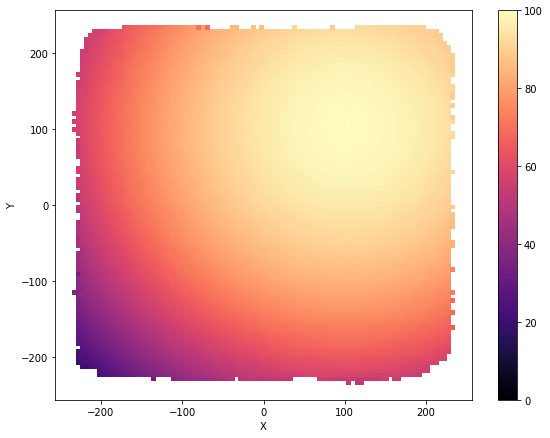

In [ ]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")

## Exploring the Effect of Learning Rate $\alpha$

In the previous section, we explored CMA-MAE using $\alpha = 0.01$, but what about other settings of $\alpha$?

In this section, we explore how different learning rate effects CMA-MAE on the sphere function.

We will first encapsulate the procedure of creating a scheduler with some `learning_rate` in a method.

In [ ]:
def create_scheduler(learning_rate):
  solution_dim = 100
  archive_dims = (100, 100)
  max_bound = solution_dim / 2 * 5.12
  bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]

  archive = GridArchive(solution_dim=solution_dim,
                        dims=archive_dims,
                        ranges=bounds,
                        learning_rate=learning_rate,
                        threshold_min=0)

  result_archive = GridArchive(solution_dim=solution_dim,
                               dims=archive_dims,
                               ranges=bounds)

  emitters = [
      EvolutionStrategyEmitter(
          archive,
          x0=np.zeros(solution_dim),
          sigma0=0.5,
          ranker="imp",
          selection_rule="mu",
          restart_rule="basic",
          batch_size=36,
      ) for _ in range(15)
  ]
  
  return Scheduler(archive, emitters, result_archive=result_archive)

Then, we will run the experiments with various learning rates while keeping track of the performance (normalized QD score and archive coverage) for each learning rate. **This took 13 minutes on Google Colab.**

> Note that the iterations is adjusted from `10000` to `5000` to save time.

In [ ]:
from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler

# The learning rates that we run CMA-MAE with.
learning_rates = [0, 0.001, 0.01, 0.1, 1]

# Run for 5000 iterations.
itrs = 5000

# Tracks the metrics of all the experiments.
all_metrics = {}

for learning_rate in learning_rates:
  # Create scheduler
  scheduler = create_scheduler(learning_rate)
  result_archive = scheduler.result_archive

  metrics = {
    "Normalized QD Score": {
        "x": [0],
        "y": [0.0],
    },
    "Archive Coverage": {
        "x": [0],
        "y": [0.0],
    },
  }

  print(f"Running CMA-MAE with learning_rate = {learning_rate}")
  for itr in range(1, itrs + 1):
    solution_batch = scheduler.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Output and record metrics every 250 iteration or on the final iteration.
    if itr % 250 == 0 or itr == itrs:
      normalized_qd_score = result_archive.stats.qd_score / result_archive.cells
      coverage_percentage = result_archive.stats.coverage * 100
      print(f"Iteration {itr} | Archive Coverage: {coverage_percentage:.3f}% "
            f"Normalized QD Score: {normalized_qd_score:.3f}")
      
      metrics["Normalized QD Score"]["x"].append(itr)
      metrics["Normalized QD Score"]["y"].append(normalized_qd_score)
      metrics["Archive Coverage"]["x"].append(itr)
      metrics["Archive Coverage"]["y"].append(coverage_percentage)
  
  all_metrics[learning_rate] = metrics


Running CMA-MAE with learning_rate = 0
Iteration 250 | Archive Coverage: 3.250% Normalized QD Score: 3.140
Iteration 500 | Archive Coverage: 3.250% Normalized QD Score: 3.140
Iteration 750 | Archive Coverage: 3.590% Normalized QD Score: 3.470
Iteration 1000 | Archive Coverage: 3.590% Normalized QD Score: 3.470
Iteration 1250 | Archive Coverage: 3.900% Normalized QD Score: 3.768
Iteration 1500 | Archive Coverage: 4.010% Normalized QD Score: 3.874
Iteration 1750 | Archive Coverage: 4.050% Normalized QD Score: 3.913
Iteration 2000 | Archive Coverage: 4.530% Normalized QD Score: 4.376
Iteration 2250 | Archive Coverage: 4.530% Normalized QD Score: 4.376
Iteration 2500 | Archive Coverage: 4.750% Normalized QD Score: 4.581
Iteration 2750 | Archive Coverage: 4.750% Normalized QD Score: 4.581
Iteration 3000 | Archive Coverage: 4.940% Normalized QD Score: 4.759
Iteration 3250 | Archive Coverage: 5.220% Normalized QD Score: 5.028
Iteration 3500 | Archive Coverage: 5.220% Normalized QD Score: 5.02

Now, we can plot the metrics for each learning rate with `matplotlib`.

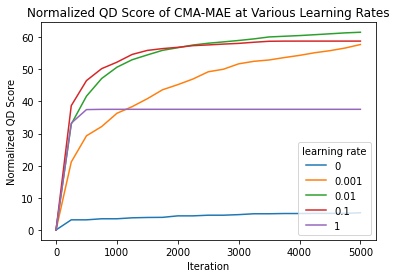

In [ ]:
for learning_rate in learning_rates:
  metrics = all_metrics[learning_rate]
  plt.plot(metrics["Normalized QD Score"]["x"], metrics["Normalized QD Score"]["y"])
  plt.title("Normalized QD Score of CMA-MAE at Various Learning Rates")
  plt.xlabel("Iteration")
  plt.ylabel("Normalized QD Score")
plt.legend(learning_rates, title="learning rate")
plt.show()

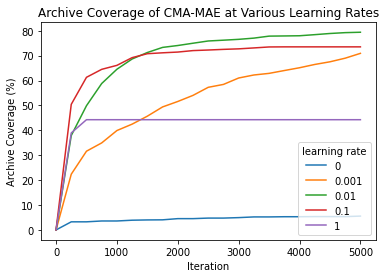

In [ ]:
for learning_rate in learning_rates:
  metrics = all_metrics[learning_rate]
  plt.plot(metrics["Archive Coverage"]["x"], metrics["Archive Coverage"]["y"])
  plt.title("Archive Coverage of CMA-MAE at Various Learning Rates")
  plt.xlabel("Iteration")
  plt.ylabel("Archive Coverage (%)")
plt.legend(learning_rates, title="learning rate")
plt.show()

From the plots, we observe the following
- With learning rate 0, the algorithm makes no progress in exploring the archive, resulting in the lowest QD score.
- With learning rate 1, the algorithm stops making progress after around 500 iterations (recall that this is the behavior of CMA-ME).
- With learning rate 0.001, the algorithm falls behind CMA-ME but consistently makes progress in exploring the archive, eventually surpassing CMA-ME at around 1500 iterations.
- With learning rate 0.01 and 0.1, the algorithm makes quick progress, surpassing the performance of all other learning rate settings.

Finally, from this experiment we observe that learning rate 0.01 is more optimal for the sphere function as the number of iteration increases.

# Extension: CMA-MAEGA with pyribs

CMA-MAEGA, proposed in the same paper as CMA-MAE, is a variant of CMA-MAE that combines archive threshold with Covariance Matrix Adaptation MAP-Elites via a Gradient Arborescence (CMA-MEGA).

> For more details on CMA-MEGA, please refer to [Fontaine 21](https://arxiv.org/abs/2106.03894)

We can easily implement this algorithm by replacing `EvolutionStrategyEmitter` with `GradientArborescenceEmitter` in CMA-MAE.

In [ ]:
from ribs.archives import GridArchive
from ribs.emitters import GradientArborescenceEmitter
from ribs.schedulers import Scheduler

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

# Use GradientArborescenceEmitter instead of EvolutionStrategyEmitter.
emitters = [
    GradientArborescenceEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=10.0,
        step_size=1.0,
        ranker="imp",
        grad_opt="gradient_ascent",
        restart_rule="basic",
        bounds=None,
        batch_size=36,
    ) for _ in range(15)
]

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

We can run the algorithm in a similar fashion as CMA-MAE. Note that since `GradientArborescenceEmitter` uses gradient information of the objective function, we need to evaluate the gradient of the solutions returned by `ask_dqd` and pass the results to `tell_dqd`.


In [ ]:
itrs = 4500

for itr in range(1, itrs + 1):
  # DQD ask-tell.
  solution_batch = scheduler.ask_dqd()

  (objective_batch, objective_grad_batch, measures_batch, measures_grad_batch) = sphere(solution_batch)

  objective_grad_batch = np.expand_dims(objective_grad_batch, axis=1)
  jacobian_batch = np.concatenate((objective_grad_batch, measures_grad_batch), axis=1)
  scheduler.tell_dqd(objective_batch, measures_batch, jacobian_batch)

  # ask-tell.
  solution_batch = scheduler.ask()
  objective_batch, _, measure_batch, _ = sphere(solution_batch)
  scheduler.tell(objective_batch, measure_batch)

  # Logging and output every 500 iteration or on final iteration.
  if itr % 500 == 0 or itr == itrs:
    normalized_qd_score = result_archive.stats.qd_score / result_archive.cells
    coverage_percentage = result_archive.stats.coverage * 100
    print(f"Iteration {itr} | Archive Coverage: {coverage_percentage:.3f}% "
          f"Normalized QD Score: {normalized_qd_score:.3f}")

Iteration 500 | Archive Coverage: 95.880% Normalized QD Score: 66.235
Iteration 1000 | Archive Coverage: 98.970% Normalized QD Score: 74.971
Iteration 1500 | Archive Coverage: 99.770% Normalized QD Score: 75.243
Iteration 2000 | Archive Coverage: 99.950% Normalized QD Score: 75.309
Iteration 2500 | Archive Coverage: 100.000% Normalized QD Score: 75.335
Iteration 3000 | Archive Coverage: 100.000% Normalized QD Score: 75.344
Iteration 3500 | Archive Coverage: 100.000% Normalized QD Score: 75.352
Iteration 4000 | Archive Coverage: 100.000% Normalized QD Score: 75.357
Iteration 4500 | Archive Coverage: 100.000% Normalized QD Score: 75.363


Notice that the CMA-MEGA fully explores the archive around 2000 iterations, which is way better than CMA-MAE. It also beats the QD score of CMA-MAE.

Now, let's visualize the result archive.

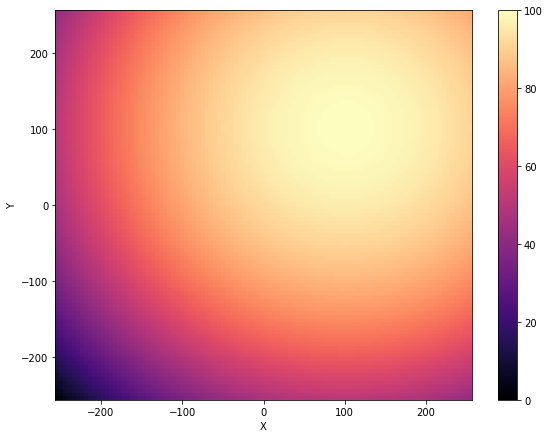

In [ ]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")
plt.show()

Although CMA-MAEGA completely blows CMA-MAE out of the way in terms of performance, unfortunately CMA-MAEGA is only useful in domain where gradient information is available.